In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

# 一、简单子结构搜索

## 1.初始化
* 初始化分子及子结构

In [2]:
m = Chem.MolFromSmiles('C2NCC2CC1C(CCCC)C(OCCCC)C1c2ccccc2')
p = Chem.MolFromSmarts('C1CCC1*')

## 2. 获取所有匹配的结构
* 获取所有匹配的结构：GetSubstructMatches()<br />
返回值是原分子中与子结构匹配的原子索引

In [3]:
matches = m.GetSubstructMatches(p)
matches

((5, 6, 11, 17, 18), (5, 17, 11, 6, 7), (6, 5, 17, 11, 12), (6, 11, 17, 5, 4))

## 3. 查看匹配的结构
* 查看匹配的结构

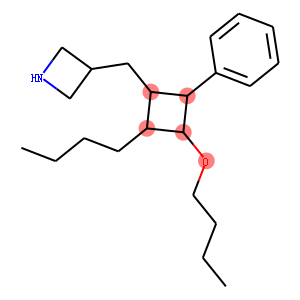

In [4]:
Draw.MolToImage(m, highlightAtoms=matches[2])

* 绘制保存

In [5]:
d = rdMolDraw2D.MolDraw2DCairo(250, 250)
rdMolDraw2D.PrepareAndDrawMolecule(d, m, highlightAtoms=list(matches[1]))
d.FinishDrawing()
d.WriteDrawingText('data/simple_structure.png')

# 二、带条件的子结构搜索
2020.03版本以后，rdkit提供了一个可选功能，用于检查并筛选出符合条件的子结构。使用的时候把这段代码粘过去，按流程操作就好了。条件可以在matchers中定义，符合matchers中指定条件的子结构才会被返回。

这个函数需要提供原始的分子和匹配原子的索引。

## 1.定义条件
* 假设要寻找一个侧链都带芳香性的子结构<br />
只需要修改matchers字典，向matchers中添加一个键值对，键为"all_aromatic"，值为判断每个原子的芳香性。

In [6]:
class SidechainChecker(object):
    # 添加条件
    matchers = {'alkyl':lambda at: not at.GetIsAromatic(),
                'all_carbon':lambda at: at.GetAtomicNum() == 6,
                'all_aromatic':lambda at: at.GetIsAromatic()}
    
    def __init__(self, query, pName='queryType'):
        # atom: [(idx, prop), ()]
        self._atsToExamin = [(x.GetIdx(), x.GetProp(pName)) for x in query.GetAtoms()
                              if x.HasProp(pName)]
        self._pName = pName
        
    def __call__(self, mol, vect):
        seen = [0] * mol.GetNumAtoms()
        for idx in vect:
            seen[idx] = 1
        for idx, qtyp in self._atsToExamin:
            midx = vect[idx]
            stack = [midx]
            atom = mol.GetAtomWithIdx(midx)
            stack = [atom]
            while stack:
                atom = stack.pop(0)
                if not self.matchers[qtyp](atom):
                    return False
                seen[atom.GetIdx()] = 1
                for nbr in atom.GetNeighbors():
                    if not seen[nbr.GetIdx()]:
                        stack.append(nbr)
        return True

## 2. 对侧链设置条件
* 给原子设置条件：SetProp(key, values)<br />
key：属性名<br />
values：属性值<br />
注：p中第五个原子（索引为4），即"*"，表示与p连接的侧链。
* 这里需要侧链带有芳香性的子结构

In [7]:
atom = p.GetAtomWithIdx(4)
atom.SetProp("queryType", "all_aromatic")

* 查看所有属性：GetPropNames()
* 查看属性值：GetProp(key)

In [8]:
print(list(atom.GetPropNames()))
atom.GetProp('queryType')

['queryType']


'all_aromatic'

## 3. 使用条件进行筛选
* 返回侧链都带有芳香性的子结构：

In [9]:
params = Chem.SubstructMatchParameters()
checker = SidechainChecker(p)
params.setExtraFinalCheck(checker)
matches = m.GetSubstructMatches(p, params)
matches

((5, 6, 11, 17, 18),)

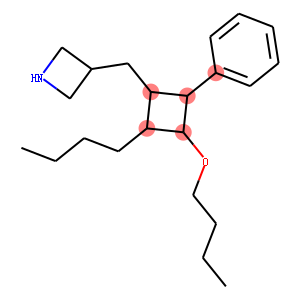

In [10]:
Draw.MolToImage(m, highlightAtoms=matches[0])

In [11]:
d = rdMolDraw2D.MolDraw2DCairo(250, 250)
rdMolDraw2D.PrepareAndDrawMolecule(d, m, highlightAtoms=list(matches[0]))
d.FinishDrawing()
d.WriteDrawingText('data/advance_structure.png')

## 4. 其他条件举例
* 返回侧链只含有碳的子结构，重新设置属性：SetProp("queryType", "all_carbon")<br />
注：all_carbon需要提取在matchers中定义好

In [12]:
atom = p.GetAtomWithIdx(4)
atom.SetProp("queryType", "all_carbon")
params = Chem.SubstructMatchParameters()
checker = SidechainChecker(p)
params.setExtraFinalCheck(checker)
matches = m.GetSubstructMatches(p, params)
matches

((5, 6, 11, 17, 18), (5, 17, 11, 6, 7))

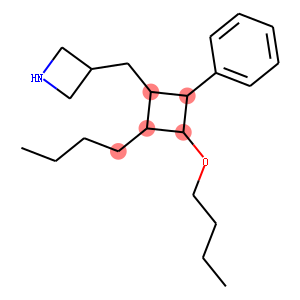

In [13]:
Draw.MolToImage(m, highlightAtoms=matches[1])